In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy.ndimage as jnd
import haiku
from PIL import Image
from IPython.display import display
import albumentations as A

import matplotlib.pyplot as plt
from einops import rearrange

%load_ext autoreload
%autoreload 2

In [2]:
import augmax

In [3]:
def float2char(image):
    return np.clip(127.5 * (1.0 + image), 0, 255).astype(np.uint8)
    
def augment1(image, transform, rng):
    display(img)
    data = jnp.asarray(img)
    aug  = transform(data, rng)
    display(Image.fromarray(np.asarray(aug)))

def augment9(image, transform, rng):
    display(img)
    data = jnp.asarray(img)
    data = jnp.stack([data]*9, axis=0)
    subkeys = jax.random.split(rng, 9)
    # aug  = jax.jit(jax.vmap(transform, [0, 0], 0))(data, subkeys)
    aug  = jax.vmap(transform, [0, 0], 0)(data, subkeys)
    aug  = rearrange(aug, '(n1 n2) h w c -> (n1 h) (n2 w) c', n1=3, n2=3)
    
    if aug.dtype == jnp.float32:
        aug = float2char(aug)
        
    display(Image.fromarray(np.asarray(aug)))

# Männchen

(512, 256, 3)


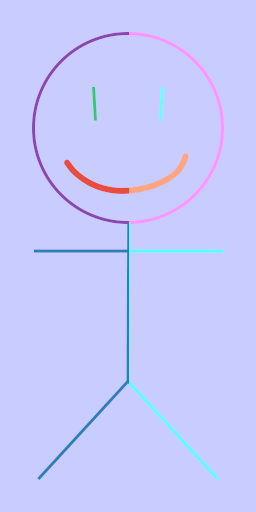

input_shape: (512, 256)
input_shape: (512, 256)


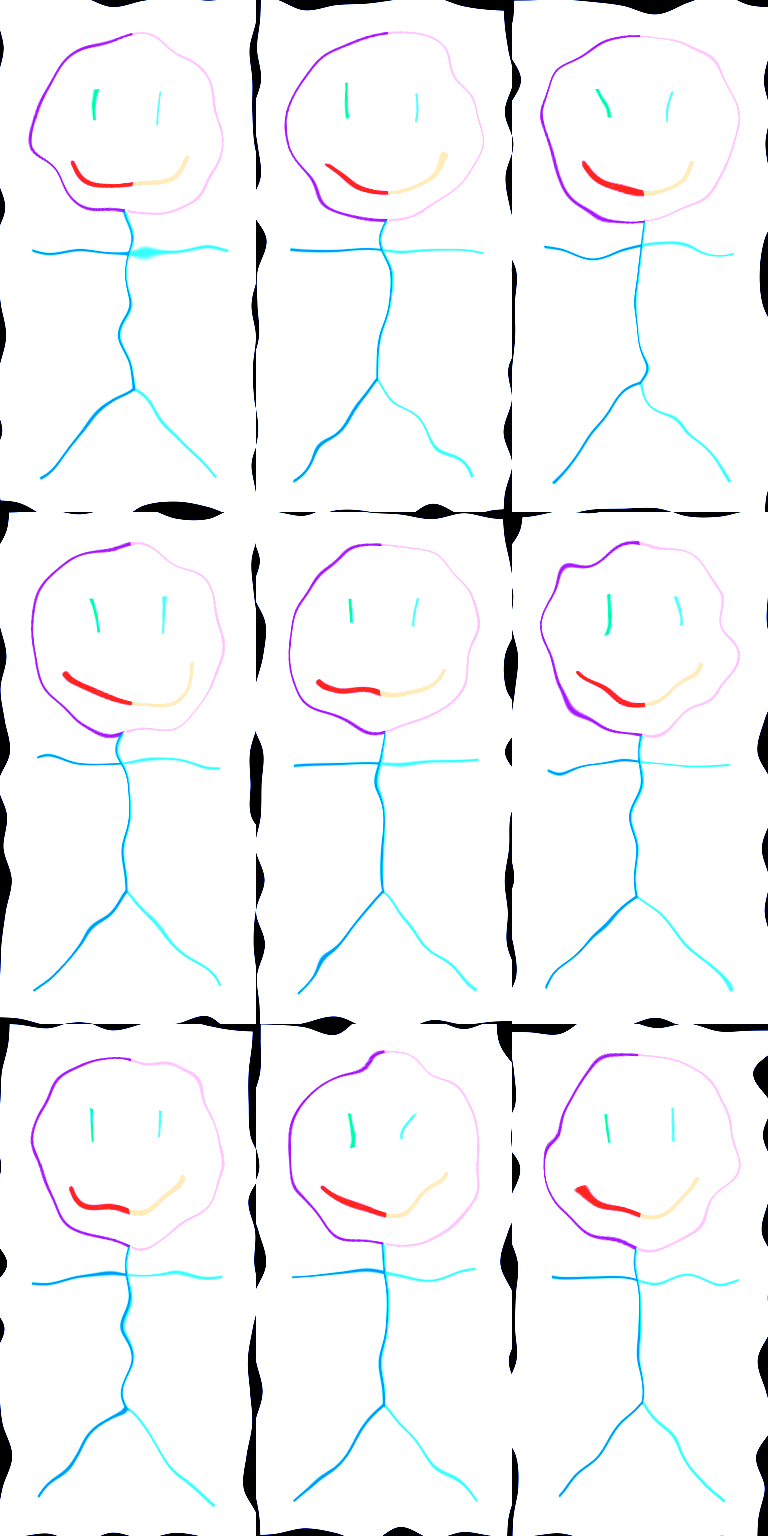

In [10]:
img = Image.open('./guy.png').convert("RGB")

data = jnp.asarray(img)
rng = jax.random.PRNGKey(0)

transform = augmax.TransformationChain(
    augmax.GeometricChain(
        augmax.Warp(),
        augmax.CenterCrop(256, 256),
        # augmax.RandomSizedCrop(256, 256, [1, 1]),
        # augmax.RandomSizedCrop(256, 256, [1, 2], prevent_underzoom=True),
        # augmax.Rotate(180, p=1.0),
        # augmax.Rotate90(),
    ),
    augmax.ColorspaceChain(
        augmax.ToFloat(),
        augmax.Normalize(),
    )
)

print(data.shape)
      
augment9(img, transform, rng)

# Showcase

In [ ]:
img = Image.open('./squirrel.jpg')
# img = Image.open('./test_center_crop.png')

display(img)
data = jnp.asarray(img)
rng = jax.random.PRNGKey(42)

transform = augmax.GeometricChain(
    augmax.Warp(),
    augmax.Rotate([-30, 30], p=1.0),
)
# transform = augmax.Warp()

transformed = transform(data, rng)

display(Image.fromarray(np.asarray(transformed)))

# Comparing with Albumentations

In [ ]:
transform = augmax.GeometricChain(
    augmax.CenterCrop([256, 256]),
    augmax.Rotate([30, 30], p=1.0),
)

albu = A.Compose([
    A.CenterCrop(256, 256),
    A.Rotate(limit=[29.9, 30])
])

In [ ]:
img = Image.open('./test_center_crop.png')
# img = Image.open('./squirrel.jpg')
display(img)
data = jnp.asarray(img)
rng = jax.random.PRNGKey(42)

transformed   = transform(data, rng)
transformed_a = albu(image=np.asarray(img))['image']

_, ax = plt.subplots(1, 2, figsize=(10, 10))

for a in ax:
    a.axis('off')
    
ax[0].imshow(np.asarray(transformed))
ax[0].set_title('Augmax')
ax[1].imshow(np.asarray(transformed_a))
ax[1].set_title('Albumentations')

In [ ]:
batch     = np.stack([np.asarray(img)] * 64, axis=0)
batch_jax = jnp.stack([jnp.asarray(img)] * 64, axis=0)

batch_transform = jax.vmap(transform, [0, None], 0)

### Albumentations Baseline

In [ ]:
%%timeit -n 100
out = np.stack([albu(image=img)['image'] for img in batch])

### Benchmark without JIT

In [ ]:
%%timeit -n 100
transformed = batch_transform(batch_jax, rng).block_until_ready()

### Benchmark with JIT

In [ ]:
%%timeit -n 100
transformed = jax.jit(batch_transform)(batch_jax, rng).block_until_ready()

### Benchmark with JIT on CPU

In [ ]:
# %%timeit -n 100
transformed = jax.jit(batch_transform, device=jax.devices('cpu'))(batch_jax, rng)

# Sanity Checks

In [ ]:
key = jax.random.PRNGKey(42)

def add_gaussian(inp, key):
    delta = jax.random.normal(key, inp.shape)
    print(inp.shape, delta.shape)
    return inp + delta

add_gaussian(jnp.zeros([1, 2, 3]), key)

In [ ]:
subkeys = jax.random.split(key, 5)

jax.vmap(add_gaussian, [0, 0], 0)(jnp.zeros(5), subkeys)

In [ ]:
subkeys